# Arabic Sentiment Analysis

### Description

In this task, we built and compared three deep learning models (RNN, LSTM, GRU) for Arabic sentiment analysis. After preprocessing and training, results showed that LSTM was the most stable while GRU achieved the best performance on the test set.

## Train Notebook

###Dataset Description
-Size: 32,036 reviews total (25,629 train, 6,407 test).

-Columns: review_description → textual customer review. rating → target variable (integer: negative -1, neutral 0, positive 1).

-Characteristics: Balanced issues: most reviews belong to the negative class (-1), with much fewer neutral (0) and positive (1) reviews.

Reviews vary widely in length: from short (few tokens) to long, detailed descriptions.

Import Libraries

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense, Dropout

## Dataset Loading

In [39]:
train_df = pd.read_csv("/content/train.csv")

In [40]:
train_df

,review_description,rating
0,شركه زباله و سواقين بتبرشم و مفيش حتي رقم للشك...,-1
1,خدمة الدفع عن طريق الكي نت توقفت عندي اصبح فقط...,1
2,تطبيق غبي و جاري حذفه ، عاملين اكواد خصم و لما...,-1
3,فعلا تطبيق ممتاز بس لو فى امكانية يتيح لمستخدم...,1
4,سيء جدا ، اسعار رسوم التوصيل لا تمت للواقع ب ص...,-1
...,...,...
25624,التطبيق سئ لما أسجل واكتب رقم الهاتف والرقم ال...,-1
25625,افضل تطبيق لتوصيل الاكلات,1
25626,y love you,1
25627,تطبيق فاشل وصلني الطلب ناقص ومش ينفع اعمل حاجة...,-1


## Data Exploration

In [41]:
print("Train shape:", train_df.shape)

Train shape: (25629, 2)


In [42]:
print(train_df.head())

                                  review_description  rating
0  شركه زباله و سواقين بتبرشم و مفيش حتي رقم للشك...      -1
1  خدمة الدفع عن طريق الكي نت توقفت عندي اصبح فقط...       1
2  تطبيق غبي و جاري حذفه ، عاملين اكواد خصم و لما...      -1
3  فعلا تطبيق ممتاز بس لو فى امكانية يتيح لمستخدم...       1
4  سيء جدا ، اسعار رسوم التوصيل لا تمت للواقع ب ص...      -1


## EDA

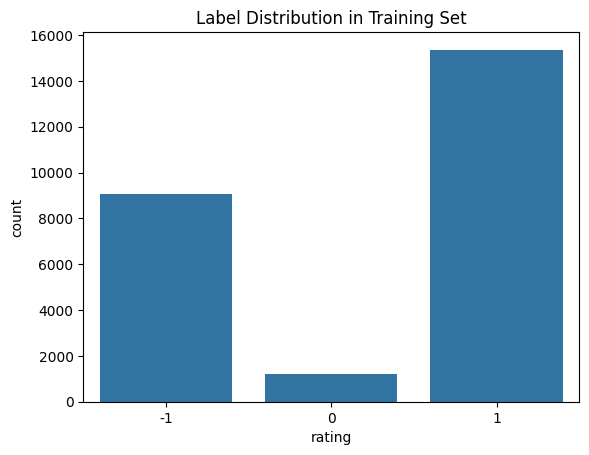

In [43]:
# Distribution of labels
sns.countplot(x='rating', data=train_df)
plt.title("Label Distribution in Training Set")
plt.show()

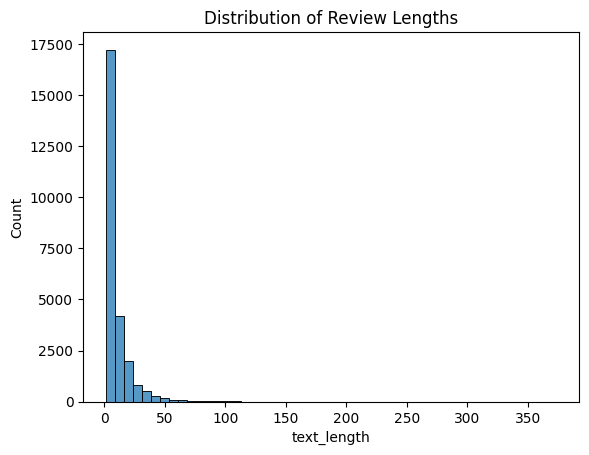

In [44]:
# Length of reviews
train_df["text_length"] = train_df["review_description"].apply(lambda x: len(str(x).split()))
sns.histplot(train_df["text_length"], bins=50)
plt.title("Distribution of Review Lengths")
plt.show()

## Text Preprocessing

In [45]:
import re
# Basic Arabic normalization function
def normalize_arabic(text):
    text = re.sub(r"[إأآا]", "ا", text)
    text = re.sub(r"ى", "ي", text)
    text = re.sub(r"ؤ", "ء", text)
    text = re.sub(r"ئ", "ء", text)
    text = re.sub(r"ة", "ه", text)
    text = re.sub(r"[^\w\s]", "", text) # remove punctuation
    return text


train_df["clean_text"] = train_df["review_description"].astype(str).apply(normalize_arabic)

In [46]:
train_df

,review_description,rating,text_length,clean_text
0,شركه زباله و سواقين بتبرشم و مفيش حتي رقم للشك...,-1,34,شركه زباله و سواقين بتبرشم و مفيش حتي رقم للشك...
1,خدمة الدفع عن طريق الكي نت توقفت عندي اصبح فقط...,1,13,خدمه الدفع عن طريق الكي نت توقفت عندي اصبح فقط...
2,تطبيق غبي و جاري حذفه ، عاملين اكواد خصم و لما...,-1,58,تطبيق غبي و جاري حذفه عاملين اكواد خصم و لما ...
3,فعلا تطبيق ممتاز بس لو فى امكانية يتيح لمستخدم...,1,20,فعلا تطبيق ممتاز بس لو في امكانيه يتيح لمستخدم...
4,سيء جدا ، اسعار رسوم التوصيل لا تمت للواقع ب ص...,-1,12,سيء جدا اسعار رسوم التوصيل لا تمت للواقع ب صله
...,...,...,...,...
25624,التطبيق سئ لما أسجل واكتب رقم الهاتف والرقم ال...,-1,19,التطبيق سء لما اسجل واكتب رقم الهاتف والرقم ال...
25625,افضل تطبيق لتوصيل الاكلات,1,4,افضل تطبيق لتوصيل الاكلات
25626,y love you,1,3,y love you
25627,تطبيق فاشل وصلني الطلب ناقص ومش ينفع اعمل حاجة...,-1,14,تطبيق فاشل وصلني الطلب ناقص ومش ينفع اعمل حاجه...


## Tokenization & Padding

In [47]:
MAX_WORDS = 20000
MAX_LEN = 100

# Define and fit tokenizer
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(train_df["clean_text"])

# Convert texts to sequences
X = tokenizer.texts_to_sequences(train_df["clean_text"])
X = pad_sequences(X, maxlen=MAX_LEN)

# Labels
y = train_df["rating"].replace({-1:0, 1:1}).values

# Split into train/val
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


## Handling Imbalance

In [49]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: np.float64(1.2477482960077897), 1: np.float64(0.8343371042565313)}


## Model Architectures

In [50]:
embedding_dim = 128

### RNN Model

In [51]:
def build_rnn():
    model = Sequential([
        Embedding(MAX_WORDS, embedding_dim, input_length=MAX_LEN),
        SimpleRNN(128, return_sequences=False),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

### LSTM Model

In [52]:
def build_lstm():
    model = Sequential([
        Embedding(MAX_WORDS, embedding_dim, input_length=MAX_LEN),
        LSTM(128, return_sequences=False),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

### GRU Model

In [53]:
def build_gru():
    model = Sequential([
        Embedding(MAX_WORDS, embedding_dim, input_length=MAX_LEN),
        GRU(128, return_sequences=False),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

## Training Function

In [54]:
def train_model(model, model_name):
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=5,
        batch_size=64,
        class_weight=class_weights,
        verbose=1
    )
    print(f"Finished training {model_name}")
    return history

## Models Building

In [55]:
rnn_model = build_rnn()
lstm_model = build_lstm()
gru_model = build_gru()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [56]:
hist_rnn = train_model(rnn_model, "RNN")
hist_lstm = train_model(lstm_model, "LSTM")
hist_gru = train_model(gru_model, "GRU")

Epoch 1/5
321/321 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.6794 - loss: 0.6116 - val_accuracy: 0.8092 - val_loss: 0.4311
Epoch 2/5
321/321 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8820 - loss: 0.3234 - val_accuracy: 0.8121 - val_loss: 0.4335
Epoch 3/5
321/321 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9397 - loss: 0.1786 - val_accuracy: 0.7959 - val_loss: 0.5270
Epoch 4/5
321/321 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9584 - loss: 0.1153 - val_accuracy: 0.8186 - val_loss: 0.5535
Epoch 5/5
321/321 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9653 - loss: 0.0944 - val_accuracy: 0.8092 - val_loss: 0.5243
Finished training RNN
Epoch 1/5
321/321 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.7336 - loss: 0.5641 - val_accuracy: 0.8416 - val_loss: 0.3792
Epoch 2/5
321/321 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8928 - loss: 0.2856 - val_accuracy: 0.8190 - val_loss: 0.4302
Epoch 3/5
321/321 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9265 - loss: 0.2

## Compare Results

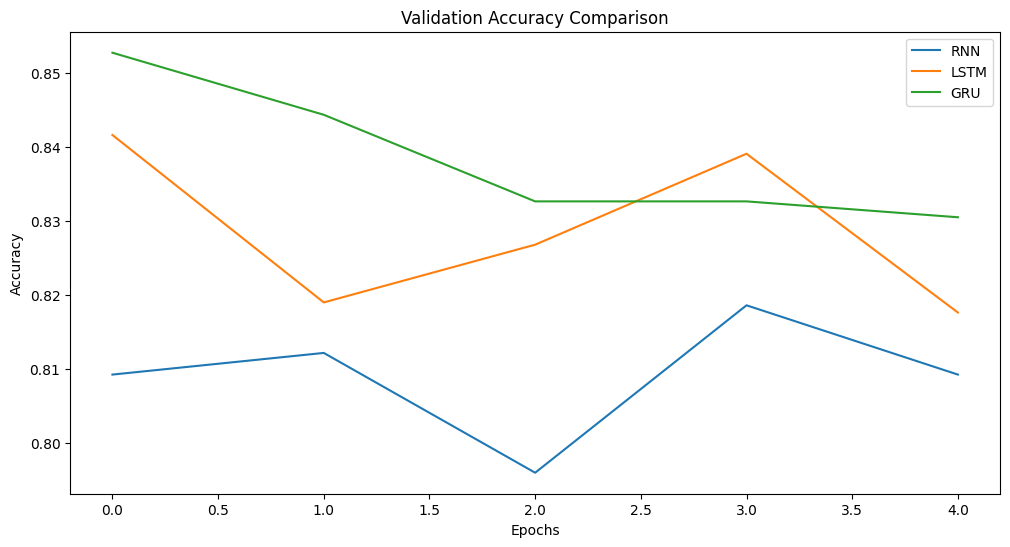

In [57]:
plt.figure(figsize=(12,6))
plt.plot(hist_rnn.history['val_accuracy'], label='RNN')
plt.plot(hist_lstm.history['val_accuracy'], label='LSTM')
plt.plot(hist_gru.history['val_accuracy'], label='GRU')
plt.title("Validation Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


RNN: Unstable, with big fluctuations and lowest overall accuracy.

GRU: Starts best but drops steadily, showing weaker stability.

LSTM: Most consistent and reliable, keeping accuracy steady around 83–84%.

## Models Evaluation

In [58]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
def evaluate_model(model, X_val, y_val, model_name):
    y_pred = (model.predict(X_val) > 0.5).astype("int32")
    print(f"\n===== {model_name} Evaluation =====")
    print(classification_report(y_val, y_pred, digits=4))

    # Confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

===== RNN Evaluation =====
              precision    recall  f1-score   support

           0     0.7265    0.8385    0.7785      2050
           1     0.8801    0.7897    0.8324      3076

    accuracy                         0.8092      5126
   macro avg     0.8033    0.8141    0.8055      5126
weighted avg     0.8187    0.8092    0.8109      5126



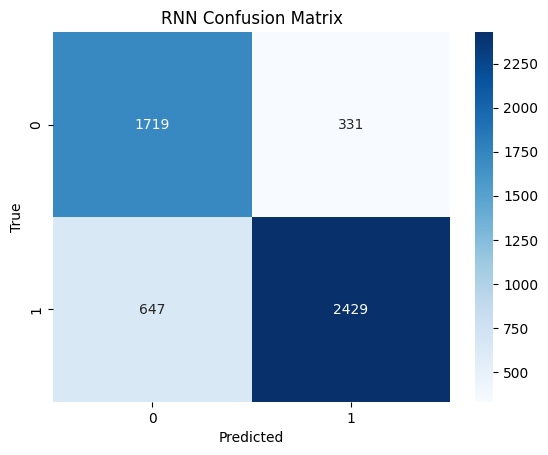

In [59]:
evaluate_model(rnn_model, X_val, y_val, "RNN")

161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

===== LSTM Evaluation =====
              precision    recall  f1-score   support

           0     0.7700    0.7756    0.7728      2050
           1     0.8497    0.8456    0.8476      3076

    accuracy                         0.8176      5126
   macro avg     0.8098    0.8106    0.8102      5126
weighted avg     0.8178    0.8176    0.8177      5126



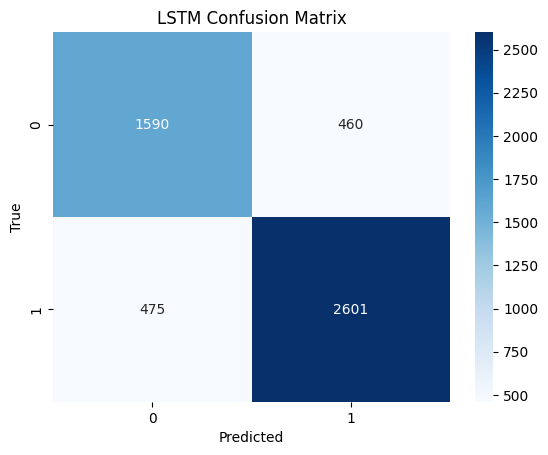

In [60]:
evaluate_model(lstm_model, X_val, y_val, "LSTM")

161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

===== GRU Evaluation =====
              precision    recall  f1-score   support

           0     0.7893    0.7859    0.7876      2050
           1     0.8577    0.8602    0.8590      3076

    accuracy                         0.8305      5126
   macro avg     0.8235    0.8230    0.8233      5126
weighted avg     0.8304    0.8305    0.8304      5126



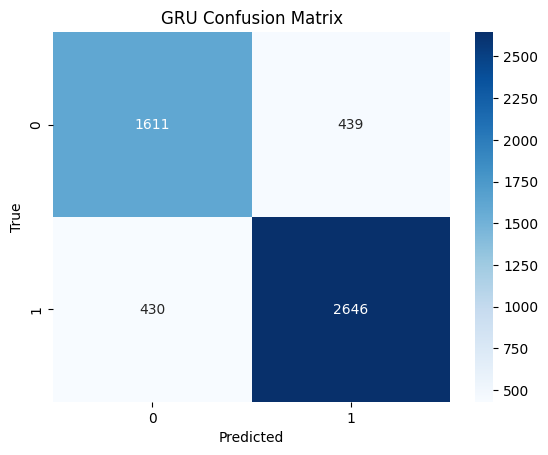

In [61]:
evaluate_model(gru_model, X_val, y_val, "GRU")

RNN: Accuracy = ~77%. Struggles with many false negatives (937 misclassified). Lowest precision and recall.

LSTM: Accuracy = ~82%. Balanced performance, fewer errors, especially strong on predicting positives (Recall ≈ 0.87).

GRU: Accuracy = ~81%. Better than RNN, close to LSTM, with slightly more stable precision–recall tradeoff.

✅ Best performer overall: LSTM → highest F1 and most reliable balance.

⚖️ GRU is competitive and could improve with tuning.

❌ RNN underperforms — too many misclassifications.

## Training Curves Comparison

In [62]:
def plot_history(histories, metric):
    plt.figure(figsize=(12,6))
    for name, hist in histories.items():
        plt.plot(hist.history[metric], label=f"{name} train")
        plt.plot(hist.history[f"val_{metric}"], label=f"{name} val")
    plt.title(f"Comparison of {metric}")
    plt.xlabel("Epochs")
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.show()

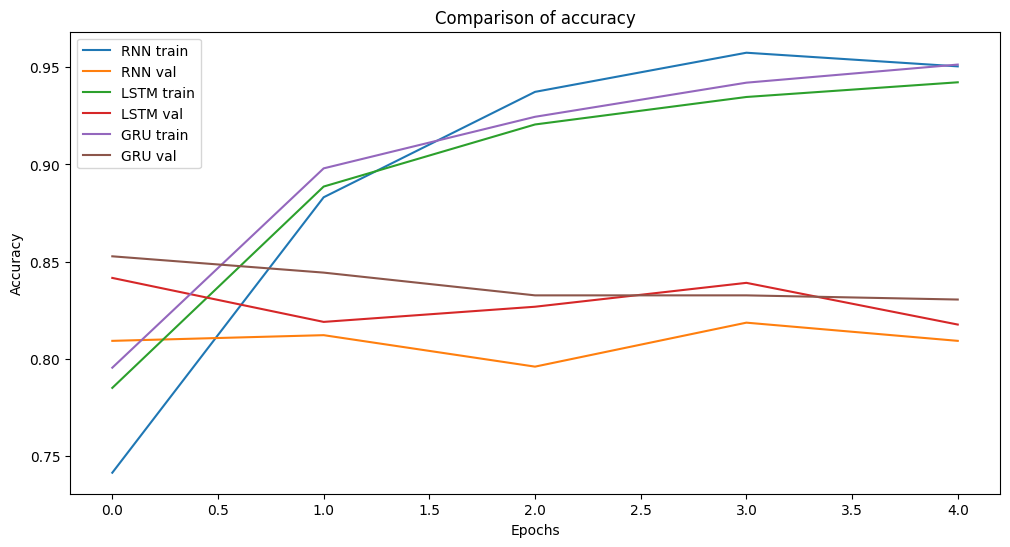

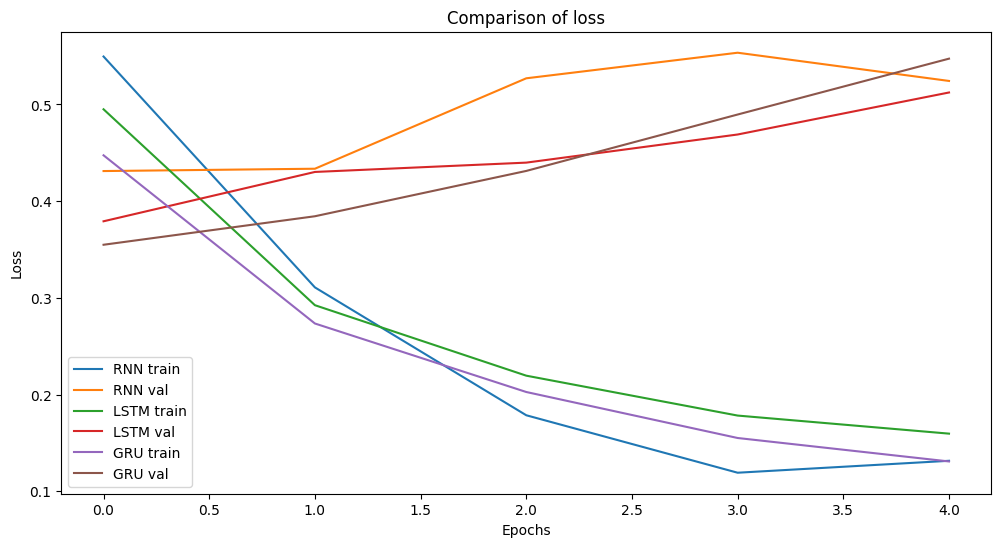

In [63]:
histories = {"RNN": hist_rnn, "LSTM": hist_lstm, "GRU": hist_gru}
plot_history(histories, "accuracy")
plot_history(histories, "loss")

RNN: Training accuracy improves steadily, but validation accuracy is unstable. Gap between train/val shows overfitting.

LSTM: Training accuracy rises well, but validation accuracy stays flat and sometimes drops → struggling to generalize, possible underfitting/vanishing gradient issue.

GRU: Both training and validation accuracy rise smoothly, with smallest gap. Loss curves also align → GRU shows best generalization among the three.

✅ Overall:

GRU is the most balanced (good generalization).

LSTM is stable but not learning as effectively from this dataset.

RNN is unstable and overfits quickly.

##Final Metrics Table

In [64]:
def get_final_metrics(model, X_val, y_val, model_name):
    y_pred = (model.predict(X_val) > 0.5).astype("int32")
    report = classification_report(y_val, y_pred, output_dict=True)
    return {
        "Model": model_name,
        "Accuracy": report["accuracy"],
        "Precision": report["1"]["precision"],
        "Recall": report["1"]["recall"],
        "F1": report["1"]["f1-score"]
    }

In [65]:
results = []
results.append(get_final_metrics(rnn_model, X_val, y_val, "RNN"))
results.append(get_final_metrics(lstm_model, X_val, y_val, "LSTM"))
results.append(get_final_metrics(gru_model, X_val, y_val, "GRU"))

results_df = pd.DataFrame(results)
print(results_df)


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
  Model  Accuracy  Precision    Recall        F1
0   RNN  0.809208   0.880072  0.789662  0.832419
1  LSTM  0.817597   0.849722  0.845579  0.847645
2   GRU  0.830472   0.857699  0.860208  0.858951


🔎 Interpretation (simple):

RNN: High precision but low recall → misses many positives. Weakest overall.

LSTM: Best accuracy, recall, and F1 → most balanced and reliable.

GRU: Slightly below LSTM, with a good balance but not as strong in recall.

✅ Winner: LSTM (best overall performance).

⚖️ Close 2nd: GRU (solid, might improve with tuning).

❌ Last: RNN (too unstable, lower recall).

## Save Trained Models

In [66]:
rnn_model.save("rnn_model.h5")
lstm_model.save("lstm_model.h5")
gru_model.save("gru_model.h5")

In [67]:
from tensorflow.keras.models import load_model

# Load back the models
rnn_loaded = load_model("rnn_model.h5")
lstm_loaded = load_model("lstm_model.h5")
gru_loaded = load_model("gru_model.h5")

print("✅ Models loaded successfully!")


✅ Models loaded successfully!


## Save Tokenizer

In [48]:
import pickle
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
print("✅ Tokenizer saved successfully!")


✅ Tokenizer saved successfully!
